# Check of YNHH and Adaptive Orthogonal Validation
- Ruoyi Jiang
- September 15, 2019
- Check of YNHH thymus overlap

In [1]:
options(warn = -1)

In [ ]:
# Set directory of pipeline_abseq
pipeline_abseq_dir <- "/git/pipeline_abseq"

# Set directory to output figures
PLOT_DIR <- "/data/plots"

# Set location of airr meta data
AIRR_META_FILE <- "/data/AIRR_BioSample_Simple.csv"

# Set location of validation RDA file
VALIDATE_RDA_FILE <- "/data/db_validate_prepare_v2.rda"

# Set location of Adaptive data file from Processing_Adaptive-FINAL.ipynb
ADAPTIVE_FILE <- "/data/adaptive_db_v2.tab"

In [2]:
# # Set directory of pipeline_abseq
# pipeline_abseq_dir <- "~/Dropbox/hg/pipeline_abseq"

# # Set directory to output figures
# PLOT_DIR <- "~/Dropbox/Projects/OConnor_Thymus/manuscript/figures/prelim"

# # Set location of airr meta data
# AIRR_META_FILE <- "~/Dropbox/Projects/OConnor_Thymus/Identification/AIRR_BioSample_Simple.csv"

# # Set location of validation RDA file
# VALIDATE_RDA_FILE <- "~/Dropbox/Projects/OConnor_Thymus/analysis/db_validate_prepare_v2.rda"

# # Set location of Adaptive data file from Processing_Adaptive-FINAL.ipynb
# ADAPTIVE_FILE <- "~/Dropbox/Projects/OConnor_Thymus/Adaptive/analysis/db_v2.tab"

In [3]:
library(dplyr)
library(tidyr)
library(alakazam)
library(shazam)
library(seqinr)
library(stringr)
library(limma)
library(ggforce)
library(RColorBrewer)

source(file.path(pipeline_abseq_dir, "api/saturn/saturn.R"))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.
As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.

Attaching package: ‘seqinr’

The following object is masked from ‘package:dplyr’:

    count


Attaching package: ‘limma’

The following object is masked from ‘package:seqinr’:

    zscore


In [4]:
TIME_COLORS <- c(
'0 Months' = '#FFD700',
'6 Months' = '#FF7F00',
'12 Months' = '#B22222',
'Thymus' = '#6495ED' 
)

# YNHH Thymus

### Read-in DF

In [15]:
META_DF <- read.csv(AIRR_META_FILE) %>%
    filter(PUBLISHED) %>%
    mutate(INDEX = row_number()) %>%
    filter((PATIENT == "X" & !grepl("CD27", SORT_ID)) & !grepl("ficoll", SORT_ID) 
           | grepl("THY", PATIENT), TIME != "Posterior_Thymus")

In [16]:
JOIN_DF <- META_DF %>%
    select(INDEX, PATIENT, STATUS, TIME, SAMPLE)

In [17]:
DF_YNHH <- META_DF %>%
    rowwise() %>%
    mutate(FILE = file.path(EXPERIMENT_DIR, PIPELINE, RUN, SAMPLE, paste0(ID, TAIL))) %>%
    #mutate(FILE = file.path(EXPERIMENT_DIR, PIPELINE, RUN, SAMPLE, paste0(SAMPLE, TAIL))) %>%
    select(INDEX, FILE) %>%
    group_by(INDEX) %>%
    do(mutate(read.csv(.$FILE, sep = '\t'), SEQORIENT = NULL))

In [21]:
DF_YNHH <- DF_YNHH %>% 
    left_join(JOIN_DF, by = "INDEX") %>%
    rowwise() %>%
    mutate(TIME = if(TIME %in% c('0','6')){paste(as.character(TIME), "Months")}else{TIME}) %>%
    filter(FUNCTIONAL) %>%
    rowwise() %>%
    mutate(CREGION_PRESTO = CREGION) %>%
    mutate(CREGION = translateStrings(CREGION, TRANS))  %>%
    mutate(PATIENT_TIME = paste(PATIENT, TIME, sep ='_'))

### Cloning

In [82]:
THRESH_LIST <- list()

for(patient in unique(DF$PATIENT)){
    print(patient) 
    
    pt_df <- DF_YNHH %>% filter(PATIENT == patient) 
    
    if(dim(pt_df)[1] > 2000){
        pt_df <- pt_df %>% sample_n(2000)
    }
    
    thresh_df <- runShazam(pt_df, NPROC=8, SUBSAMPLE = 500)
    
    THRESH_LIST[[patient]] <- thresh_df
}

[1] "X"
[1] "THY6"
[1] "THY7"
[1] "THY2"
[1] "THY8"
[1] "THY1"
[1] "THY3"
[1] "THY5"
[1] "THY4"


In [91]:
YNHH_THRESH_DF <- bind_rows(THRESH_LIST, .id="PATIENT")

In [6]:
common_threshold <- YNHH_THRESH_DF %>%
    drop_na(threshold) %>%
    group_by(PATIENT) %>%
    summarize(MEAN = mean(as.numeric(threshold))) %>%
    summarize(MEAN = mean(MEAN)) %>% select(MEAN) %>% unlist()

`summarise()` ungrouping output (override with `.groups` argument)


In [32]:
common_threshold

MEAN 
0.1706566

In [ ]:
DF_YNHH <- DF_YNHH %>%
    ungroup() %>%
    do(runDefineClones(., clone_threshold = common_threshold))

### QC Table

In [25]:
ISO_CHOICES <- c("IgM", "IgG", "IgA")

read_table <- DF_YNHH %>%
    filter(PATIENT == 'X') %>%
	filter(CREGION %in% ISO_CHOICES) %>%
	group_by(PATIENT, TIME, STATUS, CREGION) %>%
	summarize(
            CLONES = length(unique(CLONE)),
			#READS=sum(CONSCOUNT),
            UNIQ=n()
		) %>%
    ungroup() %>%
    #complete(PATIENT, TIME, CREGION, fill = list(READS=0, UNIQ=0, CLONES=0)) %>%
    rowwise() %>%
    gather(KEY, VALUE, -PATIENT, -TIME, -CREGION, -STATUS) %>%
    rowwise() %>%
    mutate(TYPE = if(KEY != "CLONES"){paste(CREGION, KEY, sep = '_')}else{"CLONES"}) %>%
    select(-CREGION, -KEY) %>%
    group_by(PATIENT, TIME, TYPE, STATUS) %>%
    summarize(VALUE = sum(VALUE)) %>%
    spread(TYPE, VALUE) 

In [26]:
read_table

PATIENT TIME     STATUS CLONES IgA_UNIQ IgG_UNIQ IgM_UNIQ
1 X       0 Months THY    42041  40447    13407    33711   
2 X       6 Months THY     7230   3997     2239     2313   
3 X       Thymus   THY    38541  14547    41682    11373

In [27]:
# append this to reads table
read_table %>% write.csv(file.path(PLOT_DIR, "reads_x_v2.csv"))

# Analysis of YNHH Thymus

In [5]:
load(VALIDATE_RDA_FILE)

In [11]:
# save(DF_YNHH,
#      YNHH_THRESH_DF,  
#      file = VALIDATE_RDA_FILE)

### Examine Overlaps

In [12]:
all_overlap_df <- DF_YNHH %>%
    runQuantifyOverlap(group = "PATIENT_TIME", clone = "CLONE", action = "frequency")

In [13]:
all_overlap_df %>%
    rowwise() %>%
    mutate(PATIENT = strsplit(as.character(PATIENT_TIME), '_')[[1]][1], TIME = strsplit(as.character(PATIENT_TIME), '_')[[1]][2]) %>%
    mutate(COMPARISON = if(grepl(PATIENT, index)){"Intra-Patient"}else{"Inter-Patient"}) %>%
    filter(!grepl("Thymus", PATIENT_TIME), index != PATIENT_TIME, grepl("Thymus", index)) %>%
    filter(PATIENT == "X") %>%
    group_by(TIME, COMPARISON) %>%
    summarize(MEAN = mean(OVERLAP))

TIME COMPARISON    MEAN       
1 0    Inter-Patient 0.026121846
2 0    Intra-Patient 0.079356214
3 12   Inter-Patient 0.008628755
4 12   Intra-Patient 0.016754671

In [6]:
all_overlap_df <- DF_YNHH %>%
    runQuantifyOverlap(group = "PATIENT_TIME", clone = "CLONE", action = "sorenson_bool")

In [7]:
all_overlap_df %>%
    rowwise() %>%
    mutate(PATIENT = strsplit(as.character(PATIENT_TIME), '_')[[1]][1], TIME = strsplit(as.character(PATIENT_TIME), '_')[[1]][2]) %>%
    mutate(COMPARISON = if(grepl(PATIENT, index)){"Intra-Patient"}else{"Inter-Patient"}) %>%
    filter(!grepl("Thymus", PATIENT_TIME), index != PATIENT_TIME, grepl("Thymus", index)) %>%
    filter(PATIENT == "X") %>%
    group_by(TIME, COMPARISON) %>%
    summarize(MEAN = mean(OVERLAP))

`summarise()` regrouping output by 'TIME' (override with `.groups` argument)


TIME COMPARISON    MEAN       
1 0    Inter-Patient 0.012116435
2 0    Intra-Patient 0.072641926
3 12   Inter-Patient 0.009519076
4 12   Intra-Patient 0.027873976

In [9]:
-log(0.072641926/0.027873976)

[1] -0.9578488

In [10]:
igg_overlap_df <- DF_YNHH %>% filter(CREGION == "IgG") %>%
    runQuantifyOverlap(group = "PATIENT_TIME", clone = "CLONE", action = "sorenson_bool")

In [11]:
igg_overlap_df  %>%
    rowwise() %>%
    mutate(PATIENT = strsplit(as.character(PATIENT_TIME), '_')[[1]][1], TIME = strsplit(as.character(PATIENT_TIME), '_')[[1]][2]) %>%
    mutate(COMPARISON = if(grepl(PATIENT, index)){"Intra-Patient"}else{"Inter-Patient"}) %>%
    filter(!grepl("Thymus", PATIENT_TIME), index != PATIENT_TIME, grepl("Thymus", index)) %>%
    filter(PATIENT == "X") %>%
    group_by(TIME, COMPARISON) %>%
    summarize(MEAN = mean(OVERLAP))

`summarise()` regrouping output by 'TIME' (override with `.groups` argument)


TIME COMPARISON    MEAN       
1 0    Inter-Patient 0.006398547
2 0    Intra-Patient 0.042923873
3 12   Inter-Patient 0.003897038
4 12   Intra-Patient 0.006429044

In [12]:
-log(0.042923873/0.006429044)

[1] -1.898602

## Venn Diagrams

In [7]:
# DF <- DF %>%
#     rowwise() %>%
#     mutate(TIME = if(TIME %in% c('0','12')){paste(as.character(TIME), "Months")}else{TIME}) %>%
#     mutate(TIME = if(TIME == "12 Months"){"6 Months"}else{TIME})

In [9]:
input_df = DF_YNHH %>%
    rowwise() #%>%
    #mutate(TIME = if(TIME == 'HD CD27+'){'Thymus'}else{TIME})
target_patient = 'X'
#target_patient = '51T002-M5'

statuses <- unique(input_df$TIME)
patients <- unique(input_df$PATIENT)

# coerces limma venncount into a dataframe
coerceDataFrame <- function(venncount){
    class(venncount) <- 'matrix'
    return(as.data.frame(venncount))
}

# isolate out thymus only clones
blood_isolate <- input_df %>%
    filter(PATIENT == target_patient, TIME != "Thymus") %>%
    group_by(CLONE, PATIENT, TIME) %>%
    summarize(BOOL = TRUE)

# isolate out blood only clones (per patient)
thymus_isolate <- input_df %>%
    filter(TIME == "Thymus") %>%
    group_by(CLONE, PATIENT, TIME) %>%
    summarize(BOOL = TRUE)

# compute sharing between thymus and blood for each patient 
data_list <- list()
for(patient in patients){
    data_list[[patient]] <- bind_rows(thymus_isolate, blood_isolate) %>%
        ungroup() %>%
        filter(TIME != 'Thymus' | PATIENT == patient) %>%
        select(-PATIENT) %>%
        spread(TIME, BOOL) %>% 
        mutate_all(funs(ifelse(is.na(.), FALSE, .))) %>% select(-CLONE)
}

In [10]:
# compute vennCounts for each patient, capture the mean count for within/without comparisons
data_df <- bind_rows(data_list, .id="PATIENT") %>%
    group_by(PATIENT) %>%
    do(coerceDataFrame((vennCounts(select(., -PATIENT))))) %>% 
    ungroup() %>%
    mutate(SAME = PATIENT == target_patient) %>%
    select(-PATIENT) %>%
    group_by(SAME, !!!rlang::syms(c('0 Months', '6 Months', 'Thymus'))) %>%
    summarize(MEAN = mean(Counts), SD = sd(Counts))

In [11]:
# isolate the same and different venn counts
df.vdc_same <- data_df %>% ungroup() %>% filter(SAME) %>% select(-SAME) %>% tail(-1) %>%
  mutate(x = c(0, 1.2, 0.8, -1.2, -0.8, 0, 0),
         y = c(1.2, -0.6, 0.5, -0.6, 0.5, -1, 0))

df.vdc_diff <- data_df %>% ungroup() %>% filter(!SAME) %>% select(-SAME)  %>% tail(-1) %>%
  mutate(x = c(0, 1.2, 0.8, -1.2, -0.8, 0, 0),
         y = c(1.2, -0.6, 0.5, -0.6, 0.5, -1, 0)) %>%
 mutate(MEAN = round(MEAN, digits=0), SD = round(SD/sqrt(n()), digits=0), 
    LABEL = paste0(as.character(MEAN)))

#,'\n±', as.character(SD)))

# set labels
labels <- data_df %>% ungroup() %>% select(-SAME, -MEAN, -SD) %>% colnames()

# set up positions for plotting
df.venn <- data.frame(x = c(-0.866, 0.866,0),
                      y = c(-0.5, -0.5, 1),
                      labels = labels)

In [72]:
totest_pre_counts <- bind_rows(data_list, .id="PATIENT") %>%
    group_by(PATIENT) %>%
    do(coerceDataFrame((vennCounts(select(., -PATIENT))))) %>% 
    rowwise() %>%
    mutate(SAME = if(PATIENT == target_patient){"Intra-Patient"}else{"Inter-Patient"}) %>%
    group_by(!!rlang::sym("0 Months"), !!rlang::sym("Thymus"), SAME, PATIENT) %>%
    select(-PATIENT) %>% 
    summarize(Counts = sum(Counts)) %>%
    filter(!!rlang::sym("0 Months"), !!rlang::sym("Thymus"))

Adding missing grouping variables: `PATIENT`


In [76]:
totest_post_counts <- bind_rows(data_list, .id="PATIENT") %>%
    group_by(PATIENT) %>%
    do(coerceDataFrame((vennCounts(select(., -PATIENT))))) %>% 
    rowwise() %>%
    mutate(SAME = if(PATIENT == target_patient){"Intra-Patient"}else{"Inter-Patient"}) %>%
    group_by(!!rlang::sym("6 Months"), !!rlang::sym("Thymus"), SAME, PATIENT) %>%
    select(-PATIENT) %>% 
    summarize(Counts = sum(Counts)) %>%
    filter(!!rlang::sym("6 Months"), !!rlang::sym("Thymus"))

Adding missing grouping variables: `PATIENT`


In [60]:
totest_triple_counts <- bind_rows(data_list, .id="PATIENT") %>%
    group_by(PATIENT) %>%
    do(coerceDataFrame((vennCounts(select(., -PATIENT))))) %>% 
    rowwise() %>%
    mutate(SAME = if(PATIENT == target_patient){"Intra-Patient"}else{"Inter-Patient"}) %>%
    select(-PATIENT) %>% filter(!!rlang::sym("0 Months"), !!rlang::sym("Thymus"), !!rlang::sym("6 Months"))

In [61]:
OVERLAP_PATIENT_COLORS = c(
"Intra-Patient" = "#636363",
'Inter-Patient' = "#bdbdbd"
)

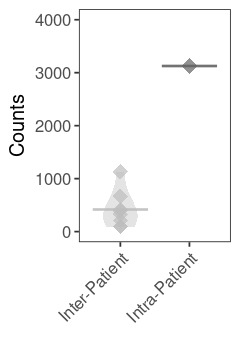

In [95]:
totest_pre_counts_sum <- totest_pre_counts %>% 
    group_by(SAME) %>%
    summarize(MEAN = mean(Counts))

options(repr.plot.width=2, repr.plot.height=3)

p <- ggplot(totest_pre_counts, aes(x=SAME, y=Counts)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    xlab("") +
    ylab(expression("Counts")) +
    scale_y_continuous(limits=c(0,4000)) +
    scale_fill_manual(values=OVERLAP_PATIENT_COLORS, name="Comparison") +
    scale_color_manual(values=OVERLAP_PATIENT_COLORS, name="Comparison") +
    geom_violin(aes(fill=SAME), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_errorbarh(data=totest_pre_counts_sum, 
                   aes(y=MEAN, color=SAME, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                   height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=SAME), position=position_dodge(0.9), size=4, pch=18, alpha=0.7)
plot(p)

In [101]:
totest_pre_counts_sum 

SAME          MEAN    
1 Inter-Patient  417.125
2 Intra-Patient 3126.000

In [96]:
plotFigure(p, file.path(PLOT_DIR, paste0("X_pre.pdf")), 2, 3)

png 
  2

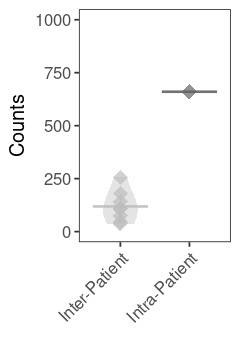

In [97]:
totest_post_counts_sum <- totest_post_counts %>% 
    group_by(SAME) %>%
    summarize(MEAN = mean(Counts))

options(repr.plot.width=2, repr.plot.height=3)

p <- ggplot(totest_post_counts, aes(x=SAME, y=Counts)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    xlab("") +
    ylab(expression("Counts")) +
    scale_y_continuous(limits=c(0,1000)) +
    scale_fill_manual(values=OVERLAP_PATIENT_COLORS, name="Comparison") +
    scale_color_manual(values=OVERLAP_PATIENT_COLORS, name="Comparison") +
    geom_violin(aes(fill=SAME), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_errorbarh(data=totest_post_counts_sum, 
                   aes(y=MEAN, color=SAME, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                   height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=SAME), position=position_dodge(0.9), size=4, pch=18, alpha=0.7)
plot(p)

In [102]:
totest_post_counts_sum 

SAME          MEAN  
1 Inter-Patient 118.75
2 Intra-Patient 660.00

In [98]:
plotFigure(p, file.path(PLOT_DIR, paste0("X_post.pdf")), 2, 3)

png 
  2

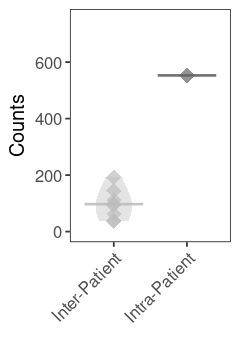

In [99]:
totest_triple_counts_sum <- totest_triple_counts %>% 
    group_by(SAME) %>%
    summarize(MEAN = mean(Counts))

options(repr.plot.width=2, repr.plot.height=3)

p <- ggplot(totest_triple_counts, aes(x=SAME, y=Counts)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    xlab("") +
    ylab(expression("Counts")) +
    scale_y_continuous(limits=c(0,750)) +
    scale_fill_manual(values=OVERLAP_PATIENT_COLORS, name="Comparison") +
    scale_color_manual(values=OVERLAP_PATIENT_COLORS, name="Comparison") +
    geom_violin(aes(fill=SAME), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_errorbarh(data=totest_triple_counts_sum, 
                   aes(y=MEAN, color=SAME, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                   height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=SAME), position=position_dodge(0.9), size=4, pch=18, alpha=0.7)
plot(p)

In [100]:
plotFigure(p, file.path(PLOT_DIR, paste0("X_triple.pdf")), 2, 3)

png 
  2

In [92]:
t.test(filter(totest_pre_counts, SAME == "Intra-Patient")$Counts - 
            filter(totest_pre_counts, SAME == "Inter-Patient")$Counts 
            , mu = 0, alternative = "greater")


	One Sample t-test

data:  filter(totest_pre_counts, SAME == "Intra-Patient")$Counts - filter(totest_pre_counts,     SAME == "Inter-Patient")$Counts
t = 22.269, df = 7, p-value = 4.654e-08
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 2478.417      Inf
sample estimates:
mean of x 
 2708.875 


In [93]:
t.test(filter(totest_post_counts, SAME == "Intra-Patient")$Counts - 
            filter(totest_post_counts, SAME == "Inter-Patient")$Counts 
            , mu = 0, alternative = "greater")


	One Sample t-test

data:  filter(totest_post_counts, SAME == "Intra-Patient")$Counts -     filter(totest_post_counts, SAME == "Inter-Patient")$Counts
t = 21.011, df = 7, p-value = 6.956e-08
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 492.4449      Inf
sample estimates:
mean of x 
   541.25 


In [94]:
t.test(filter(totest_triple_counts, SAME == "Intra-Patient")$Counts - 
            filter(totest_triple_counts, SAME == "Inter-Patient")$Counts 
            , mu = 0, alternative = "greater")


	One Sample t-test

data:  filter(totest_triple_counts, SAME == "Intra-Patient")$Counts -     filter(totest_triple_counts, SAME == "Inter-Patient")$Counts
t = 24.122, df = 7, p-value = 2.677e-08
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 420.07    Inf
sample estimates:
mean of x 
  455.875 


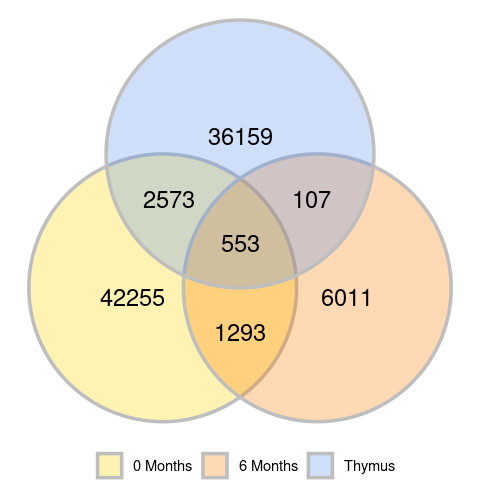

In [19]:
options(repr.plot.width=4, repr.plot.height=4)
p <- ggplot(df.venn) +
      geom_circle(aes(x0 = x, y0 = y, r = 1.5, fill = labels), alpha = .3, size = 1, colour = 'grey') +
      coord_fixed() +
      theme_void() +
      theme(legend.position = 'bottom') +
      scale_fill_manual(values = TIME_COLORS) +
      scale_colour_manual(values = TIME_COLORS, guide = FALSE) +
      labs(fill = NULL) +
      annotate("text", x = df.vdc_same$x, y = df.vdc_same$y, label = df.vdc_same$MEAN, size = 5)
plot(p)

In [20]:
plotFigure(p, file.path(PLOT_DIR, "YNHH_same_v2.pdf"), 4, 4)

png 
  2

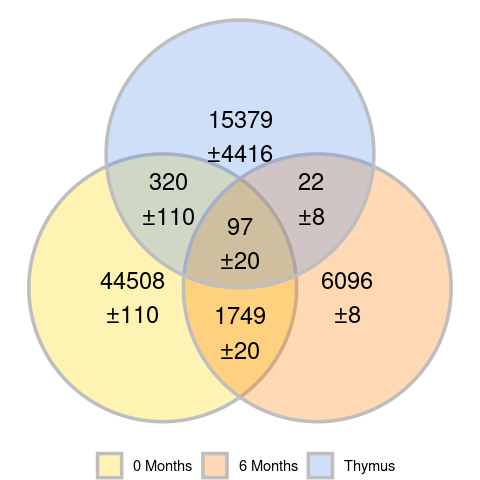

In [21]:
options(repr.plot.width=4, repr.plot.height=4)
p <- ggplot(df.venn) +
      geom_circle(aes(x0 = x, y0 = y, r = 1.5, fill = labels), alpha = .3, size = 1, colour = 'grey') +
      coord_fixed() +
      theme_void() +
      theme(legend.position = 'bottom') +
      scale_fill_manual(values = TIME_COLORS) +
      scale_colour_manual(values = TIME_COLORS, guide = FALSE) +
      labs(fill = NULL) +
      annotate("text", x = df.vdc_diff$x, y = df.vdc_diff$y, label = df.vdc_diff$LABEL, size = 5)
plot(p)

In [22]:
plotFigure(p, file.path(PLOT_DIR, "YNHH_diff_v2.pdf"), 4, 4)

png 
  2

# Adaptive

In [172]:
DF_ADAPTIVE <- readChangeoDb(ADAPTIVE_FILE) %>%
    mutate(STATUS = TIME)

Warning message:
“Missing column names filled in: 'X1' [1]”Warning message:
“Missing column names filled in: 'X1' [1]”

In [173]:
read_table <- DF_ADAPTIVE %>%
    group_by(PATIENT, TIME) %>%
    summarize(COUNT = n(), CLONES = length(unique(CLONE)))

read_table

PATIENT TIME     COUNT CLONES
1 THY2    0 Months  640   609  
2 THY2    Thymus   1826  1749  
3 THY6    0 Months 7825  7683  
4 THY6    Thymus   2413  2266  
5 THY7    0 Months 2341  2290  
6 THY7    Thymus   3430  3171

In [174]:
read_table %>% write.csv(file.path(PLOT_DIR, "adaptive_reads.csv"))

In [175]:
dtn_tab <- DF_ADAPTIVE %>%
    group_by(PATIENT) %>%
    do(distToNearest(., vCallColumn = "V_CALL_ADAPTIVE", 
    jCallColumn = "J_CALL_ADAPTIVE", model="ham", first=FALSE, normalize="len", nproc=1)) %>%
    ungroup() %>%
    do(distToNearest(., vCallColumn = "V_CALL_ADAPTIVE", 
    jCallColumn = "J_CALL_ADAPTIVE", model="ham", first=FALSE, normalize="len", cross="PATIENT", nproc=1))

In [176]:
dtn_sum <- dtn_tab %>%
    group_by(PATIENT) %>%
    do(data.frame(DENSITY = hist(.$DIST_NEAREST, plot=FALSE, breaks=seq(0,1,by=0.02))$density)) %>%
    mutate(BINS = 1:n()/length(DENSITY), TYPE = 'DTN')

cross_sum <- dtn_tab %>%
    group_by(PATIENT) %>%
    do(data.frame(DENSITY = -1 * hist(.$CROSS_DIST_NEAREST, plot=FALSE, breaks=seq(0,1,by=0.02))$density)) %>%
    mutate(BINS = 1:n()/length(DENSITY), TYPE = 'CROSS')

toplot_df <- bind_rows(dtn_sum, cross_sum)

In [177]:
common_threshold <- 0.07742428

In [178]:
DTN_COLORS <- c(
'DTN' = '#636363',
'CROSS' = '#BDBDBD'
)

In [179]:
plot_list <- list()

for(patient in unique(dtn_tab$PATIENT)){
    
#     THRESHOLD <- thresh_df %>%
#         filter(PATIENT == patient) %>%
#         select(MEAN) %>% as.numeric()
    
    THRESHOLD <- common_threshold

    plot_list[[patient]] <- ggplot(filter(toplot_df, PATIENT == patient), 
             aes(x=BINS, y=DENSITY, fill=TYPE)) + 
        baseTheme() + 
        theme_bw() + 
        theme(legend.position="none") +
        xlab("Normalized hamming distance (Junction)") + 
        ylab("Density") +
        ggtitle(paste("Patient", patient)) +
        geom_bar(stat = "identity") +
        geom_vline(xintercept=THRESHOLD, color="firebrick", linetype=2) +
        scale_x_continuous(limits=c(0,0.75)) +
        scale_y_continuous(labels=abs) +
        scale_color_manual(values=DTN_COLORS) +
        scale_fill_manual(values=DTN_COLORS)
        #facet_grid(. ~ SUBJECT) +
        #facet_wrap(~ Sample, ncol=4, scales = "free_y")
    
}

Warning message:
“Removed 26 rows containing missing values (position_stack).”Warning message:
“Removed 26 rows containing missing values (position_stack).”Warning message:
“Removed 26 rows containing missing values (position_stack).”Warning message:
“Removed 26 rows containing missing values (position_stack).”Warning message:
“Removed 26 rows containing missing values (position_stack).”

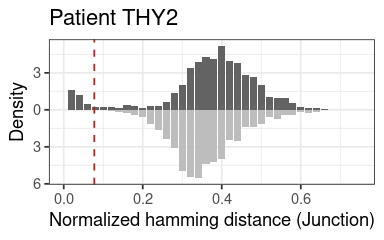

Warning message:
“Removed 26 rows containing missing values (position_stack).”

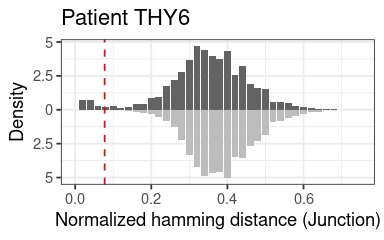

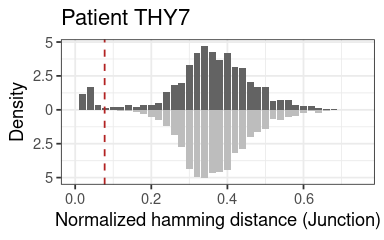

In [180]:
options(repr.plot.width=3.2, repr.plot.height=2)


for(patient in unique(dtn_tab$PATIENT)){
    pdf(file.path(PLOT_DIR, paste0(patient, "_dtn.pdf")), 3.2, 2)
    plot(plot_list[[patient]])
    dev.off()
    
#     svg(file.path(PLOT_DIR, paste0(patient, "_dtn.svg")), 3.2, 2)
#     plot(plot_list[[patient]])
#     dev.off()
    plot(plot_list[[patient]])
}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

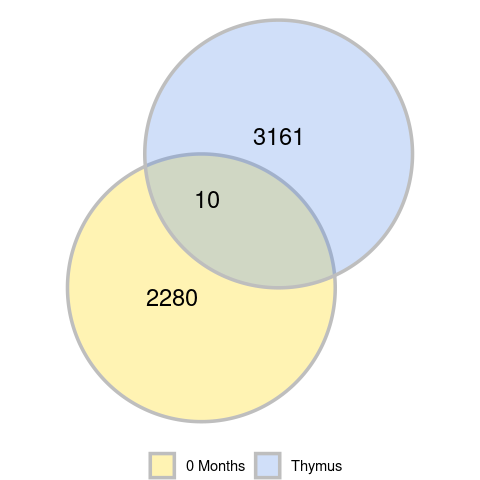

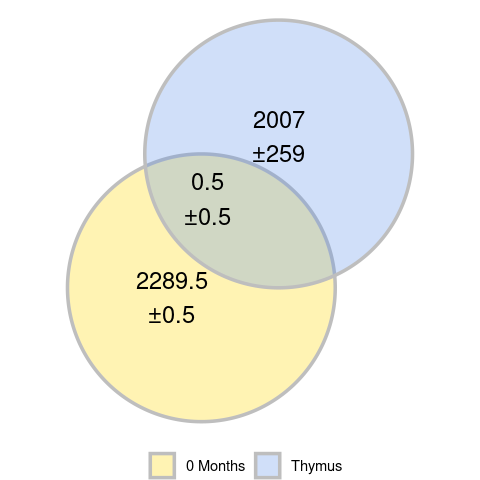

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

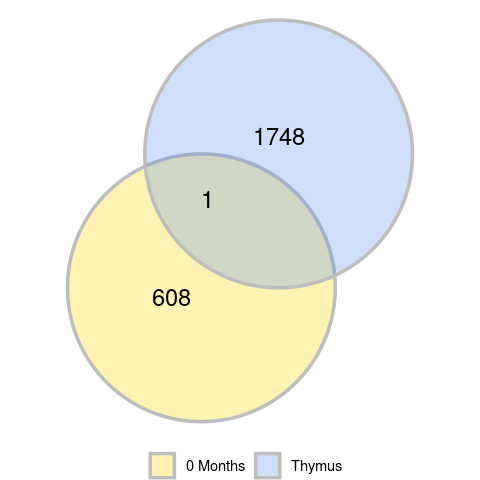

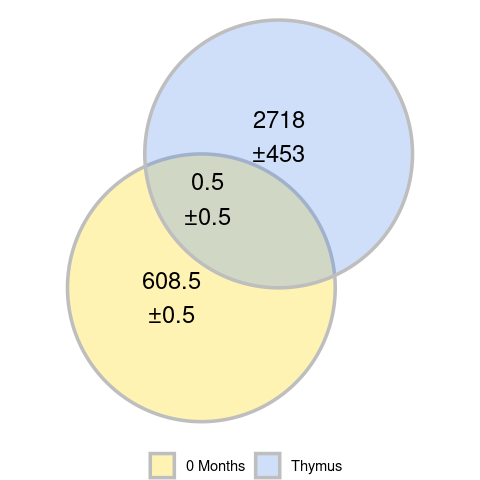

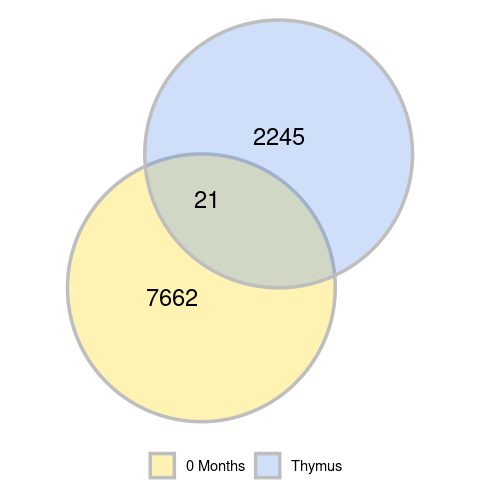

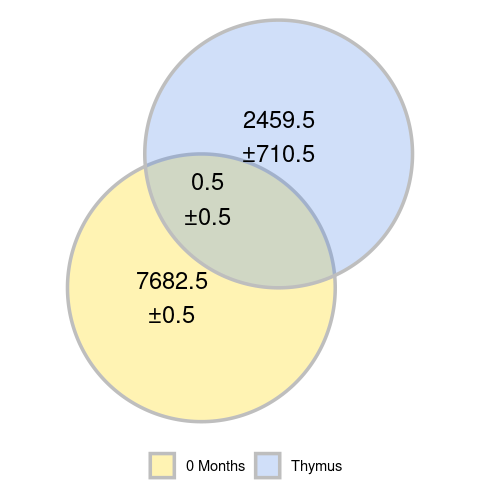

In [181]:
for(target_patient in unique(DF_ADAPTIVE$PATIENT)){
    input_df = DF_ADAPTIVE %>%
    rowwise() #%>%
    #mutate(STATUS = if(STATUS == 'HD CD27+'){'Thymus'}else{STATUS})
    #target_patient = '51T002-M5'

    statuses <- unique(input_df$STATUS)
    patients <- unique(input_df$PATIENT)

    # coerces limma venncount into a dataframe
    coerceDataFrame <- function(venncount){
        class(venncount) <- 'matrix'
        return(as.data.frame(venncount))
    }

    # isolate out thymus only clones
    blood_isolate <- input_df %>%
        filter(PATIENT == target_patient, STATUS != "Thymus") %>%
        group_by(CLONE, PATIENT, STATUS) %>%
        summarize(BOOL = TRUE)

    # isolate out blood only clones (per patient)
    thymus_isolate <- input_df %>%
        filter(STATUS == "Thymus") %>%
        group_by(CLONE, PATIENT, STATUS) %>%
        summarize(BOOL = TRUE)

    # compute sharing between thymus and blood for each patient 
    data_list <- list()
    for(patient in patients){
        data_list[[patient]] <- bind_rows(thymus_isolate, blood_isolate) %>%
            ungroup() %>%
            filter(STATUS != 'Thymus' | PATIENT == patient) %>%
            select(-PATIENT) %>%
            spread(STATUS, BOOL) %>% 
            mutate_all(funs(ifelse(is.na(.), FALSE, .))) %>% select(-CLONE)
    }

    # compute vennCounts for each patient, capture the mean count for within/without comparisons
    data_df <- bind_rows(data_list, .id="PATIENT") %>%
        group_by(PATIENT) %>%
        do(coerceDataFrame((vennCounts(select(., -PATIENT))))) %>% 
        ungroup() %>%
        mutate(SAME = PATIENT == target_patient) %>%
        select(-PATIENT) %>%
        group_by(SAME, !!!rlang::syms(c('0 Months', 'Thymus'))) %>%
        summarize(MEAN = mean(Counts), SD = sd(Counts))

    # isolate the same and different venn counts
    df.vdc_same <- data_df %>% ungroup() %>% filter(SAME) %>% select(-SAME) %>% tail(-1) %>%
      mutate(x = c(0, -1.2, -0.8),
             y = c(1.2, -0.6, 0.5))

    df.vdc_diff <- data_df %>% ungroup() %>% filter(!SAME) %>% select(-SAME)  %>% tail(-1) %>%
      mutate(x = c(0, -1.2, -0.8),
             y = c(1.2, -0.6, 0.5)) %>%
     mutate(MEAN = round(MEAN, digits=1), SD = round(SD/sqrt(n()-1), digits=1), 
        LABEL = paste0(as.character(MEAN),'\n±', as.character(SD)))

    # set labels
    labels <- data_df %>% ungroup() %>% select(-SAME, -MEAN, -SD) %>% colnames()

    # set up positions for plotting
    df.venn <- data.frame(x = c(-0.866, 0),
                          y = c(-0.5, 1),
                          labels = labels)

    options(repr.plot.width=4, repr.plot.height=4)
    p <- ggplot(df.venn) +
          geom_circle(aes(x0 = x, y0 = y, r = 1.5, fill = labels), alpha = .3, size = 1, colour = 'grey') +
          coord_fixed() +
          theme_void() +
          theme(legend.position = 'bottom') +
          scale_fill_manual(values = TIME_COLORS) +
          scale_colour_manual(values = TIME_COLORS, guide = FALSE) +
          labs(fill = NULL) +
          annotate("text", x = df.vdc_same$x, y = df.vdc_same$y, label = df.vdc_same$MEAN, size = 5)
    plot(p)
    plotFigure(p, file.path(PLOT_DIR, paste0(target_patient, "_same.pdf")), 4, 4)

    options(repr.plot.width=4, repr.plot.height=4)
    p <- ggplot(df.venn) +
          geom_circle(aes(x0 = x, y0 = y, r = 1.5, fill = labels), alpha = .3, size = 1, colour = 'grey') +
          coord_fixed() +
          theme_void() +
          theme(legend.position = 'bottom') +
          scale_fill_manual(values = TIME_COLORS) +
          scale_colour_manual(values = TIME_COLORS, guide = FALSE) +
          labs(fill = NULL) +
          annotate("text", x = df.vdc_diff$x, y = df.vdc_diff$y, label = df.vdc_diff$LABEL, size = 5)
    plot(p)
    plotFigure(p, file.path(PLOT_DIR, paste0(target_patient, "_diff.pdf")), 4, 4)

}